<a href="https://colab.research.google.com/github/nortonvanz/Texas_Airbnb/blob/main/NPS_Texas_Airbnb_c1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objetivo

Dataset: Rio Airbnb



Objectives - Cycle 1:

Using pyspark:

- 1 Eliminate properties without review
- 2 Identify customers who were detractors in some evaluation
- 3 Get bag of words from these negative reviews

# Cycle 1

## Imports

### PySpark

In [1]:
#pyspark libs and dependencies
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark

In [1]:
import os
import findspark

#configure JAVA_HOME and SPARK_HOME environment variables in Google Colab, indicating where Java and Apache Spark are installed in the environment
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

#Launch findspark, a Python library that helps you locate the Apache Spark installation on your system and configure the Python environment to interact with Spark.
findspark.init()

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

#Create a Spark session using the PySpark library
spark = SparkSession.builder \
    .master('local[*]') \
    .appName('Iniciando com Spark') \
    .config('spark.ui.port', '4050') \
    .getOrCreate()

### Imports

In [68]:
#extract gzip
import gzip
import shutil

#sentiment analysis
from textblob import TextBlob

#User Defined Function (UDF)
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

#Bag of words
from pyspark.ml.feature import Tokenizer, CountVectorizer, StopWordsRemover
from pyspark.ml import Pipeline
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

#regular
import matplotlib.pyplot as plt

## Load data

In [5]:
#Upload datasets directly from Inside Airbnb to the Colab temporary environment:
  #Dasets: http://insideairbnb.com/get-the-data/

# listings.csv.gz = Detailed Listings Data
!wget --quiet --show-progress http://data.insideairbnb.com/united-states/tx/austin/2023-09-10/data/listings.csv.gz

# reviews.csv.gz = Detailed Review Data (.gz, contains comments, not on summarized .csv)
!wget --quiet --show-progress http://data.insideairbnb.com/united-states/tx/austin/2023-09-10/data/reviews.csv.gz

listings.csv.gz     100%[===================>]   9.99M  36.1MB/s    in 0.3s    
reviews.csv.gz      100%[===================>]  53.55M  25.4MB/s    in 2.1s    


In [6]:
#unzip datasets:

input_file = "reviews.csv.gz"
output_file = "reviews.csv"

with gzip.open(input_file, 'rb') as f_in:
    with open(output_file, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
print(f'O arquivo {input_file} foi descompactado para {output_file}.')


input_file2 = "listings.csv.gz"
output_file2 = "listings.csv"

with gzip.open(input_file2, 'rb') as f_in:
    with open(output_file2, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
print(f'O arquivo {input_file2} foi descompactado para {output_file2}.')

O arquivo reviews.csv.gz foi descompactado para reviews.csv.
O arquivo listings.csv.gz foi descompactado para listings.csv.


In [4]:
# Load real estate dataset
df_houses = spark.read.csv("listings.csv", header=True, inferSchema=True)

# Load review dataset
df_reviews = spark.read.csv("reviews.csv", header=True, inferSchema=True)

In [5]:
#houses
df_houses.show(3)

+----+--------------------+--------------+------------+---------------+--------------------+--------------------+---------------------+--------------------+-------+--------------------+---------+----------+-------------+--------------------+------------------+------------------+--------------------+-----------------+--------------------+--------------------+------------------+-------------------+-------------------------+--------------------+--------------------+----------------------+--------------------+----------------------+----------------------------+--------+---------+--------------------+---------------+------------+---------+--------------+--------+----+--------------------+--------------------+--------------------+--------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+--------------------+-----------------+--------------------+--------------------+---------------+----------

In [6]:
#rows
df_houses.count()

24182

In [7]:
#reviews
df_reviews.show(3)

+----------+-------+----------+-----------+-------------+--------------------+
|listing_id|     id|      date|reviewer_id|reviewer_name|            comments|
+----------+-------+----------+-----------+-------------+--------------------+
|      5456|    865|2009-03-08|       5267|        Ellen|Sylvia is a hoste...|
|    282342| 913203|2012-02-11|     633688|      Claudia|This is a fantast...|
|    282342|1064098|2012-03-31|    1613219|        Kerry|Chris and his fam...|
+----------+-------+----------+-----------+-------------+--------------------+
only showing top 3 rows



In [8]:
#rows
df_reviews.count()

583744

## Create Views

In [9]:
#create views from datasets
df_houses.createOrReplaceTempView("houses")
df_reviews.createOrReplaceTempView("reviews")

## 1 Eliminate properties without review

In [15]:
# Select 1 property: https://www.airbnb.com.br/rooms/5456

In [10]:
#SPARK SQL
spark.sql('''
          SELECT
            *
          FROM houses h
          WHERE h.id = 5456

        ''').show(10, truncate=False)

+----+---------------------------------+--------------+------------+-----------+----------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [11]:
# Select reviews from property

In [12]:
spark.sql('''
          SELECT
            *
          FROM reviews
          WHERE listing_id = 5456

          --WHERE EXTRACT (YEAR FROM date) = 2023
          --AND reviewer_name = 'Sneha'

        ''').show(10,truncate=False) #)

+----------+----+----------+-----------+------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|listing_id|id  |date      |reviewer_id|reviewer_name     |comments                                                                                                                                                                                                                                                                                                                                                            

In [13]:
#Create new dataset just w/ properties with review:

houses_w_review = spark.sql('''
          SELECT
            *
          FROM houses h
          WHERE h.id IN (SELECT listing_id FROM reviews)

        ''')

houses_w_review.show(5)

+--------+--------------------+--------------+------------+---------------+--------------------+--------------------+---------------------+--------------------+--------+--------------------+-----------+----------+-------------+--------------------+------------------+------------------+--------------------+-----------------+--------------------+--------------------+------------------+-------------------+-------------------------+--------------------+--------------------+----------------------+--------------------+----------------------+----------------------------+--------+---------+-------------+---------------+------------+---------+--------------+--------+----+--------------------+----------------+--------------------+--------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------+--------------------+--------------------+---------------+--------------------+---------------

In [14]:
houses_w_review.count()

11758

In [15]:
#total number of houses w/ review = 11758

In [16]:
#replace view
houses_w_review.createOrReplaceTempView("houses")

In [17]:
#select from dataset created
spark.sql('''
          SELECT
           *
          FROM houses
        ''').show(5) #,truncate=False)

+--------+--------------------+--------------+------------+---------------+--------------------+--------------------+---------------------+--------------------+--------+--------------------+-----------+----------+-------------+--------------------+------------------+------------------+--------------------+-----------------+--------------------+--------------------+------------------+-------------------+-------------------------+--------------------+--------------------+----------------------+--------------------+----------------------+----------------------------+--------+---------+-------------+---------------+------------+---------+--------------+--------+----+--------------------+----------------+--------------------+--------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------+--------------------+--------------------+---------------+--------------------+---------------

## 2 Identify customers who were detractors in some evaluation

In [113]:
#objective: identify from comments, which customers were detractors in some review

In [18]:
#extract evaluation from column name, and create new view with column evaluation:
houses_w_ratings = spark.sql('''
          SELECT
              id,
              name,
              regexp_extract(name, '★([0-9]*\.[0-9]+)', 1) AS evaluation,
              host_location,
              latitude,
              longitude,
              property_type,
              accommodates
          FROM
              houses
          WHERE
              name LIKE "%★%"
        ''')

#create view from dataset
houses_w_ratings.createOrReplaceTempView("houses_w_ratings")

In [19]:
#houses_w_ratings view:
spark.sql('''
          SELECT
             *
          FROM houses_w_ratings
        ''').show(5) #,truncate=False)

+--------+--------------------+----------+-------------+--------+---------+-------------+------------+
|      id|                name|evaluation|host_location|latitude|longitude|property_type|accommodates|
+--------+--------------------+----------+-------------+--------+---------+-------------+------------+
|17239710|Tiny home in Aust...|      4.95|   Austin, TX|    null|     null|         null|        null|
|18227140|Home in Austin · ...|      4.95|     Kyle, TX| 30.2205|-97.70055|  Entire home|          12|
|20932451|Home in Austin · ...|      4.98|   Austin, TX|30.25544|-97.73423|  Entire home|          16|
|21098269|Loft in Austin · ...|      4.95|   Austin, TX|30.26014| -97.7154|  Entire loft|           2|
| 2322667|Home in Austin · ...|       5.0|   Austin, TX|    null|     null|         null|        null|
+--------+--------------------+----------+-------------+--------+---------+-------------+------------+
only showing top 5 rows



In [20]:
#identify properties with evaluation < 2, to get an example
spark.sql('''
          SELECT
             *
          FROM houses_w_ratings
          WHERE evaluation < 2 AND evaluation > 0
        ''').show(10) #,truncate=False)

+------------------+--------------------+----------+-------------+------------------+------------------+--------------------+------------+
|                id|                name|evaluation|host_location|          latitude|         longitude|       property_type|accommodates|
+------------------+--------------------+----------+-------------+------------------+------------------+--------------------+------------+
|844172257191676124|Home in Austin · ...|      1.40|         null|30.390417104953457|-97.68489815675012|Private room in home|           3|
+------------------+--------------------+----------+-------------+------------------+------------------+--------------------+------------+



In [21]:
#check property evaluations: id 844172257191676124

five_neg_comments = spark.sql('''
          SELECT
             *
          FROM reviews
          where listing_id = 844172257191676124
        ''')

five_neg_comments.show(10, truncate=False) #)

+------------------+------------------+----------+-----------+---------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|listing_id        |id                |date      |reviewer_id|reviewer_name  |comments                             

In [22]:
#these 5 customers above were detractors.
#Run sentiment analysis trying to identify them all, from their comments

### Sentiment Analysis

In [23]:
# Define a UDF (User Defined Function) for sentiment analysis

def analyze_sentiment(comment):
   # Check if comment is not None
    if comment is not None:
        analysis = TextBlob(comment)
        if analysis.sentiment.polarity > 0:
            return 'Positive'
        elif analysis.sentiment.polarity == 0:
            return 'Neutral'
        else:
            return 'Negative'
    else:
        return 'N/A'  # You can handle None values as needed

In [24]:
#test function with first comment:
analyze_sentiment("TERRIBLE TERRIBLE. I have been using Airbnb for some years now and have NEVER left a bad review. <br/>This is the first person to truly have poor customer service. From taking hours to send the information to get inside (which happened to include incorrect lock codes). The house is very run down. Showers crusty with no towels. Had to wait 2 full hours to get inside the house after he came to see what was going on. He refused to provide any partial refund after all the inconvenience. <br/>An absolute mess. I’d recommend paying an extra $5-10 and just getting a different airbnb within the same area to potentially save you some trouble and headaches. Hope this helped, I tried to be as genuine as possible. <br/>Airbnb support was extremely helpful with this poor situation so I am grateful for them.")


'Negative'

In [25]:
#worked

#create new column in df_reviews
df_reviews.show(3)

+----------+-------+----------+-----------+-------------+--------------------+
|listing_id|     id|      date|reviewer_id|reviewer_name|            comments|
+----------+-------+----------+-----------+-------------+--------------------+
|      5456|    865|2009-03-08|       5267|        Ellen|Sylvia is a hoste...|
|    282342| 913203|2012-02-11|     633688|      Claudia|This is a fantast...|
|    282342|1064098|2012-03-31|    1613219|        Kerry|Chris and his fam...|
+----------+-------+----------+-----------+-------------+--------------------+
only showing top 3 rows



In [26]:
#In PySpark, a User Defined Function (UDF) allows you to define a custom function in Python and apply it to columns in a PySpark DataFrame

# Register the UDF with Spark
sentiment_udf = udf(analyze_sentiment, StringType()) #StringType: specifies the return type of the UDF, was set string to return 'Positive', 'Neutral', or 'Negative'

In [27]:
#Once the UDF is registered, you can use it with the withColumn method to apply the sentiment analysis function to a specific column in a PySpark DataFrame.
df_reviews_w_sentiment = df_reviews.withColumn('sentiment', sentiment_udf(df_reviews['comments']))

In [28]:
#New dataframe with sentiments:
df_reviews_w_sentiment.show(3)

+----------+-------+----------+-----------+-------------+--------------------+---------+
|listing_id|     id|      date|reviewer_id|reviewer_name|            comments|sentiment|
+----------+-------+----------+-----------+-------------+--------------------+---------+
|      5456|    865|2009-03-08|       5267|        Ellen|Sylvia is a hoste...| Positive|
|    282342| 913203|2012-02-11|     633688|      Claudia|This is a fantast...| Positive|
|    282342|1064098|2012-03-31|    1613219|        Kerry|Chris and his fam...| Positive|
+----------+-------+----------+-----------+-------------+--------------------+---------+
only showing top 3 rows



In [29]:
#Create new view with sentiment:
df_reviews_w_sentiment.createOrReplaceTempView("reviews_w_sentiments")

In [30]:
#check those 5 negative coments, if were identified as negative:
spark.sql('''
          SELECT
             *
          FROM reviews_w_sentiments
          where listing_id = 844172257191676124
        ''').show(10, truncate=False) #)

+------------------+------------------+----------+-----------+---------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|listing_id        |id                |date      |reviewer_id|reviewer_name  |comments                   

In [31]:
#Interesing stuff:
  # Positive: Second was kind of ironic, not mentioning negative words, and was classified as positive
  # Neutral: Fifth was neutral, but it's Spanish
  # Negative: 3 others

In [32]:
#save in parquet
df_reviews_w_sentiment.write.mode("overwrite").parquet("df_reviews_w_sentiment.parquet")

In [161]:
#takes long time on Colab
spark.sql('''
          SELECT
            *
          FROM reviews_w_sentiments
          WHERE sentiment IN ('Positive', 'Neutral', 'Negative')
          LIMIT 100
        ''').show(10) #, truncate=False

+----------+--------+----------+-----------+-------------+--------------------+---------+
|listing_id|      id|      date|reviewer_id|reviewer_name|            comments|sentiment|
+----------+--------+----------+-----------+-------------+--------------------+---------+
|      5456|     865|2009-03-08|       5267|        Ellen|Sylvia is a hoste...| Positive|
|    282342|  913203|2012-02-11|     633688|      Claudia|This is a fantast...| Positive|
|    282342| 1064098|2012-03-31|    1613219|        Kerry|Chris and his fam...| Positive|
|    282342| 2169298|2012-09-02|    2713331|        Ahmed|Excellent place, ...| Positive|
|    282342|11345168|2014-03-31|   11182084|           El|What a great expe...| Positive|
|    282342|29277617|2015-04-06|   11182084|           El|The Hosts are ver...| Positive|
|    282342|42656166|2015-08-15|   25544985|        Bryce|Theresa and her h...| Positive|
|    282342|51428284|2015-10-20|   32434752|         Ines|The hosts were ve...| Positive|
|    28234

In [162]:
#takes long time on Colab

#count number of negative, neutral and positive:
df_reviews_w_sentiment.groupby("sentiment").count().show()  #more than min and nothing

+---------+------+
|sentiment| count|
+---------+------+
| Positive|545489|
|  Neutral| 12182|
|      N/A| 20717|
| Negative|  5356|
+---------+------+



In [ ]:
# there is a bunch of negative comments

In [33]:
# Create dataset lighter just with negative reviews
neg_rev = spark.sql('''
          SELECT
            *
          FROM reviews_w_sentiments
          WHERE sentiment = 'Negative'
        ''')

In [34]:
#save in parquet
neg_rev.write.mode("overwrite").parquet("neg_reviews.parquet")

In [35]:
neg_rev.count()

5356

## 3 Get bag of words from all negative reviews

In [36]:
#check some Negative classified reviews:
neg_rev.show(10, truncate=False)

+-------------------------+------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------+------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [54]:
#get 100 rows to get its comments as as sample
neg_rev_sample = neg_rev.limit(300)

In [55]:
neg_rev_sample.select("comments").show(3, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Use NLTK (Natural Language Toolkit), that provides a list of English stopwords that you can use to filter out common words from your text data.

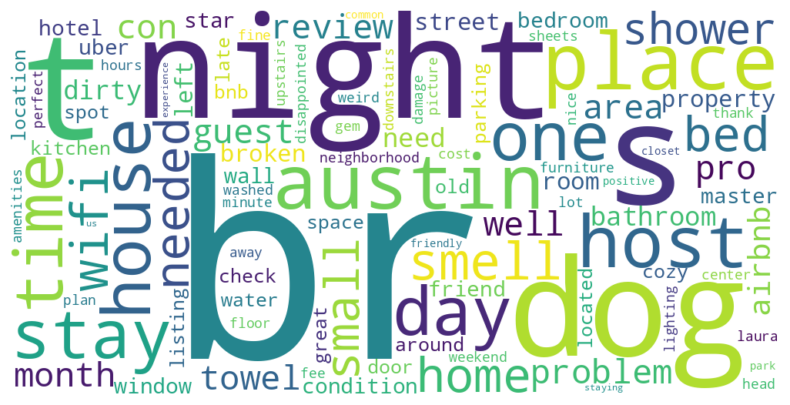

In [83]:
#without removing stopwords:

In [ ]:
#removing stopwords (fix it)

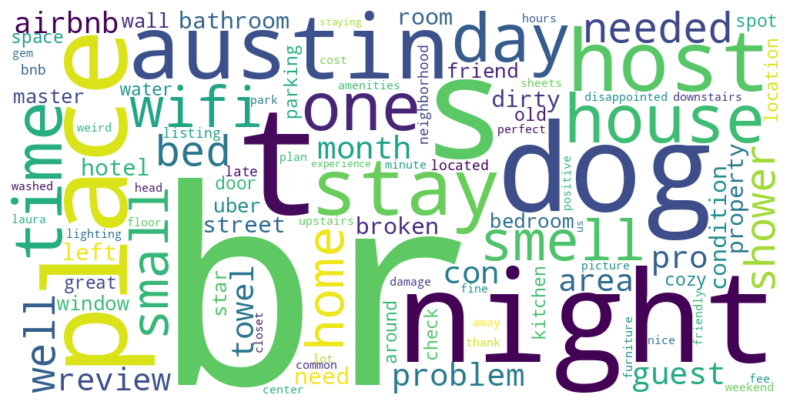

In [109]:
# Define Tokenizer
tokenizer = Tokenizer(inputCol="comments", outputCol="words")

# Remove stopwords from the "words" column
stop_words = set(stopwords.words("english"))

#remove also the word 'br', very frequent
stop_words.add('br')

# Create remover
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words", stopWords=list(stop_words))

# Count the term frequencies in the "filtered_words" column
count_vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features")

# Create a pipeline to execute the stages in order
pipeline = Pipeline(stages=[tokenizer, stopwords_remover, count_vectorizer])

# Fit the pipeline on the DataFrame
model = pipeline.fit(neg_rev_sample.select("comments"))

# Transform the DataFrame to get the bag of words representation
result = model.transform(neg_rev_sample.select("comments"))

# Display the result
# result.select("comments", "features").show(5, truncate=False)

# Extract the vocabulary and term frequency vectors
vocabulary = model.stages[-1].vocabulary
term_frequencies = result.select("features").collect()[0]["features"].toArray()

# Convert to a text string for WordCloud
wordcloud_text = " ".join([vocabulary[i] for i in range(len(vocabulary))])

# Generate WordCloud with adjusted parameters
wordcloud = WordCloud(width=1000, height=500, max_words=100, background_color="white").generate_from_text(wordcloud_text)

# Display the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()